<a href="https://colab.research.google.com/github/Anik-et/Neural_Networks/blob/main/02_DeepConvolutionalGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Importing  libraries

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

We are loading fashion mnist data .The generator will generate fashion items resembling the fashion MNIST data.

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

 Reshaping the images to add one more dimension i.e Channel. As the images are gray-scale so Channel dimension will be 1. Also,Normalizing the images to [-1, 1]because the generator’s final layer activation uses tanh

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [4]:
train_images.shape

(60000, 28, 28, 1)

Training set is prepared by dividing the whole data into batches and shuffling it.

In [5]:
buffer_size = 60000
batch_size = 32

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size ).batch(batch_size)

Both the generator and discriminator are defined using the Keras Sequential API.

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28X28x1. Notice the tf.keras.layers.ReLU activation for each layer, except the output layer which uses tanh.

Blocks 2, 3 consist of a convolution transpose(upsampling) layer, followed by a batch-normalization layer and an activation function, ReLU.
The last block comprises no batch-normalization layer, with a sigmoid activation function.

Note that activation in final layer is tanh which outputs in the range -1 to 1.Code for GAN architecture is based on this link https://www.tensorflow.org/tutorials/generative/dcgan and the original paper link on  which architecture is based is here-https://arxiv.org/pdf/1511.06434.pdf

In [7]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, input_shape = (100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))

    return model

Building the generator model and summary is obtained

In [8]:
generator = generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

Using the (as yet untrained) generator to create an random colored image.

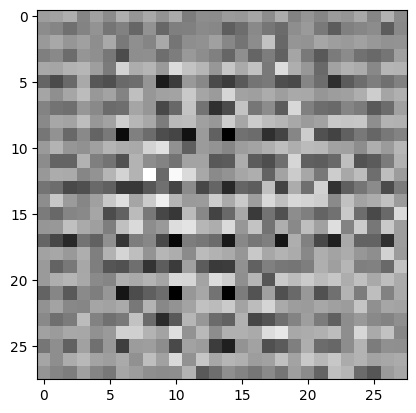

In [9]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

The discriminator is a CNN-based image classifier.
Inputs an image of dimension 28 X 28 X 1
Outputs a score between 0 and 1(sigmoid activation in final layer)
Batch normalisation layer is applied for intermediate layers
Has Leaky-Relu (with a slope of 0.2) as an activation function in the intermediate layers along with dropout layers
Has a Sigmoid activation function in the output layer.Note that we can also leave the last layer without sigmoid activation and use_logits=True in Binary Cross entropy function(which is recommended but we have done it this way  for ease in calculating real and fake scores with their display)

In [10]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same',
                            input_shape = [28, 28, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

Building the discriminator model and summary is obtained

In [11]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                     

Here We are using  the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output values > 0.5  for real images, and values <0.5 for fake images.

In [12]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.5001285]], shape=(1, 1), dtype=float32)


Now We are defining loss functions. In this case it is Binary Cross entropy as target is real or fake images

In [13]:
bce = tf.keras.losses.BinaryCrossentropy()

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

The discriminator and the generator optimizers are different since  two networks would be trained separately.

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

Following code demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

We are using `tf.function`
This annotation causes the function to be "compiled".


In [18]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Notice `training` is set to False.
This is so all layers run in inference mode (batchnorm).
Function for generating and saving images is defined

In [19]:
def generate_and_plot_images(model, epoch, test_input):

    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pred = (predictions[i, :, :, 0] + 1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [21]:
def train(dataset, epochs):

    gen_loss_list = []
    disc_loss_list = []

    real_score_list = []
    fake_score_list = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss/num_batches
        mean_disc_loss = total_disc_loss/num_batches

        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

Finally, it’s time to train GAN model in Tensorflow. Taking the train_dataset and epochs as the parameters, the  train function calls the train_step function, at every new batch.At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look more real.

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 1875 batches..
Losses after epoch     1: generator 1.707, discriminator 0.648, real_score 78.99%, fake_score 25.15%


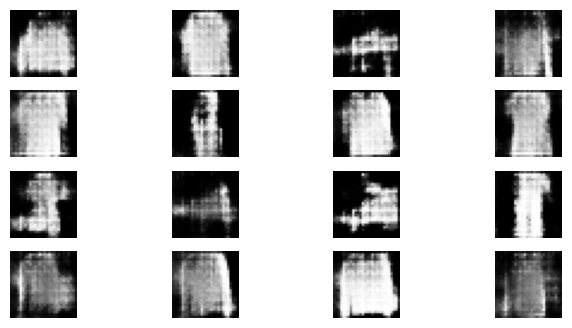

  2%|▏         | 1/50 [00:20<16:29, 20.20s/it]

Time for epoch 1 is 20.19808340072632 sec
Training started with  epoch 2 with 1875 batches..
Losses after epoch     2: generator 1.463, discriminator 1.051, real_score 59.27%, fake_score 31.07%


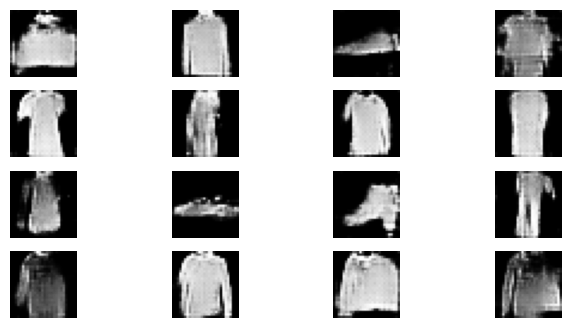

  4%|▍         | 2/50 [00:34<13:33, 16.95s/it]

Time for epoch 2 is 14.678215742111206 sec
Training started with  epoch 3 with 1875 batches..
Losses after epoch     3: generator 1.286, discriminator 1.292, real_score 51.85%, fake_score 34.22%


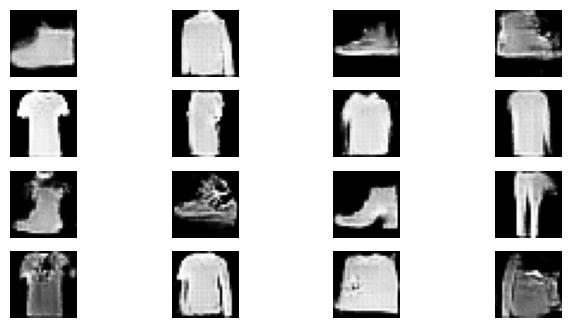

  6%|▌         | 3/50 [00:49<12:20, 15.76s/it]

Time for epoch 3 is 14.324098825454712 sec
Training started with  epoch 4 with 1875 batches..
Losses after epoch     4: generator 0.878, discriminator 1.474, real_score 50.42%, fake_score 46.63%


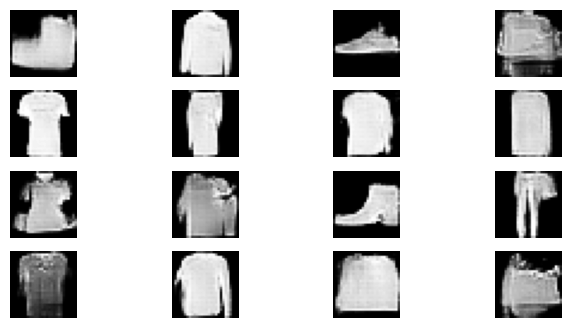

  8%|▊         | 4/50 [01:05<12:05, 15.78s/it]

Time for epoch 4 is 15.803869724273682 sec
Training started with  epoch 5 with 1875 batches..
Losses after epoch     5: generator 0.854, discriminator 1.397, real_score 56.06%, fake_score 47.04%


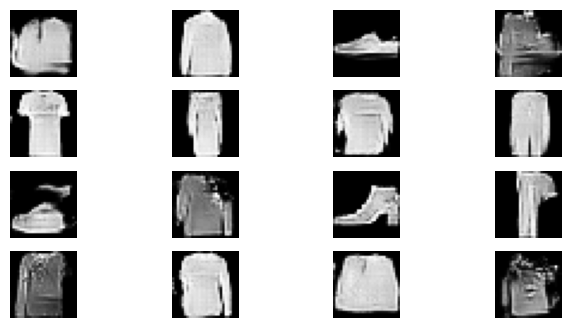

 10%|█         | 5/50 [01:19<11:28, 15.31s/it]

Time for epoch 5 is 14.479251623153687 sec
Training started with  epoch 6 with 1875 batches..
Losses after epoch     6: generator 0.932, discriminator 1.042, real_score 66.97%, fake_score 43.39%


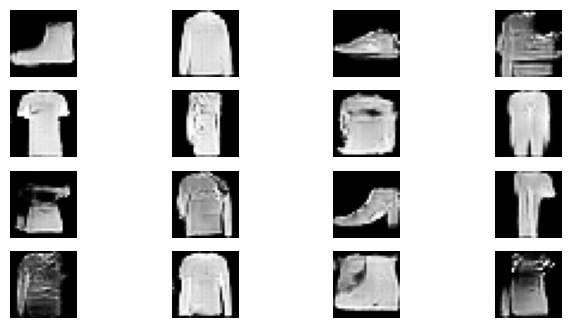

 12%|█▏        | 6/50 [01:34<11:12, 15.29s/it]

Time for epoch 6 is 15.233289003372192 sec
Training started with  epoch 7 with 1875 batches..
Losses after epoch     7: generator 0.933, discriminator 1.327, real_score 54.17%, fake_score 43.64%


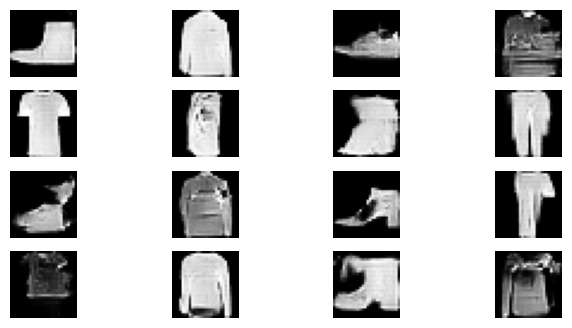

 14%|█▍        | 7/50 [01:49<10:54, 15.22s/it]

Time for epoch 7 is 15.077318668365479 sec
Training started with  epoch 8 with 1875 batches..
Losses after epoch     8: generator 0.883, discriminator 1.215, real_score 57.93%, fake_score 44.70%


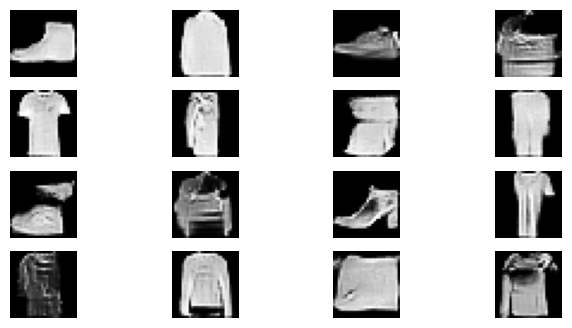

 16%|█▌        | 8/50 [02:04<10:34, 15.10s/it]

Time for epoch 8 is 14.845972299575806 sec
Training started with  epoch 9 with 1875 batches..
Losses after epoch     9: generator 0.866, discriminator 1.322, real_score 52.35%, fake_score 44.57%


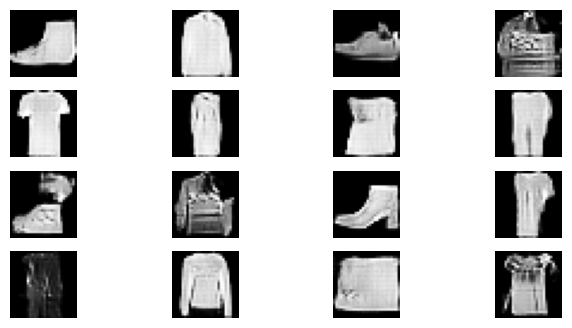

 18%|█▊        | 9/50 [02:19<10:17, 15.06s/it]

Time for epoch 9 is 14.982560396194458 sec
Training started with  epoch 10 with 1875 batches..
Losses after epoch    10: generator 1.072, discriminator 1.174, real_score 54.81%, fake_score 39.32%


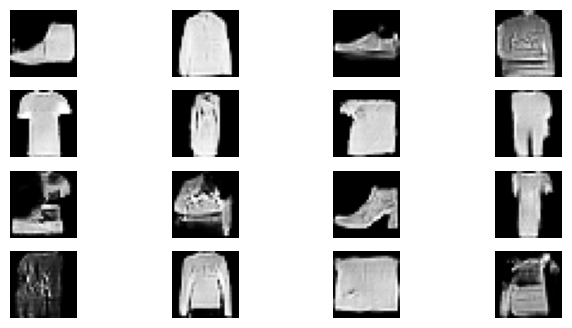

 20%|██        | 10/50 [02:35<10:11, 15.28s/it]

Time for epoch 10 is 15.750651121139526 sec
Training started with  epoch 11 with 1875 batches..
Losses after epoch    11: generator 1.050, discriminator 1.381, real_score 44.26%, fake_score 37.63%


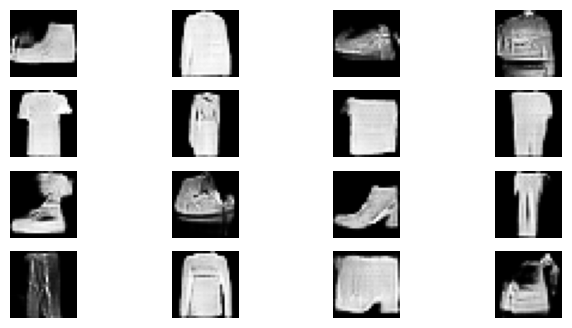

 22%|██▏       | 11/50 [02:50<09:53, 15.21s/it]

Time for epoch 11 is 15.0516357421875 sec
Training started with  epoch 12 with 1875 batches..
Losses after epoch    12: generator 0.883, discriminator 1.253, real_score 53.14%, fake_score 42.75%


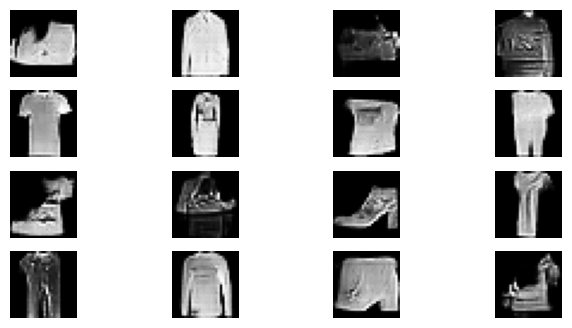

 24%|██▍       | 12/50 [03:05<09:34, 15.13s/it]

Time for epoch 12 is 14.943336486816406 sec
Training started with  epoch 13 with 1875 batches..
Losses after epoch    13: generator 1.174, discriminator 1.065, real_score 56.86%, fake_score 32.73%


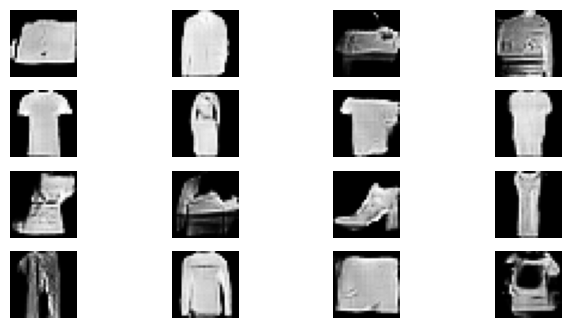

 26%|██▌       | 13/50 [03:20<09:16, 15.05s/it]

Time for epoch 13 is 14.84871768951416 sec
Training started with  epoch 14 with 1875 batches..
Losses after epoch    14: generator 0.722, discriminator 1.288, real_score 61.49%, fake_score 51.12%


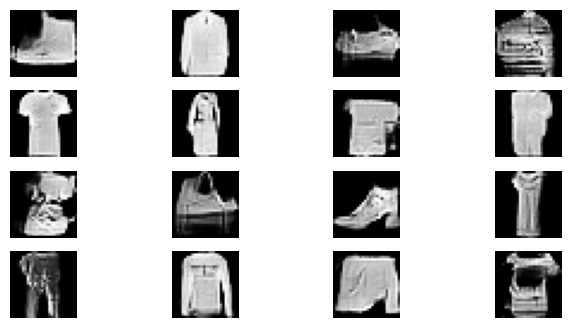

 28%|██▊       | 14/50 [03:35<09:05, 15.16s/it]

Time for epoch 14 is 15.416817903518677 sec
Training started with  epoch 15 with 1875 batches..
Losses after epoch    15: generator 0.939, discriminator 1.194, real_score 60.70%, fake_score 43.13%


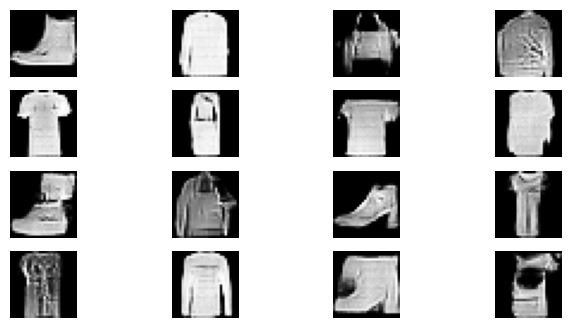

 30%|███       | 15/50 [03:50<08:49, 15.13s/it]

Time for epoch 15 is 15.070158004760742 sec
Training started with  epoch 16 with 1875 batches..
Losses after epoch    16: generator 0.824, discriminator 1.172, real_score 62.23%, fake_score 46.05%


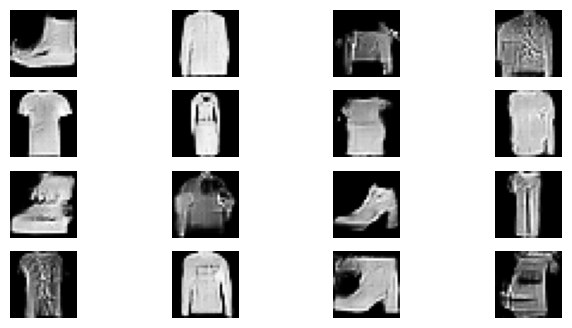

 32%|███▏      | 16/50 [04:05<08:33, 15.09s/it]

Time for epoch 16 is 14.97903060913086 sec
Training started with  epoch 17 with 1875 batches..
Losses after epoch    17: generator 0.994, discriminator 1.277, real_score 51.04%, fake_score 40.62%


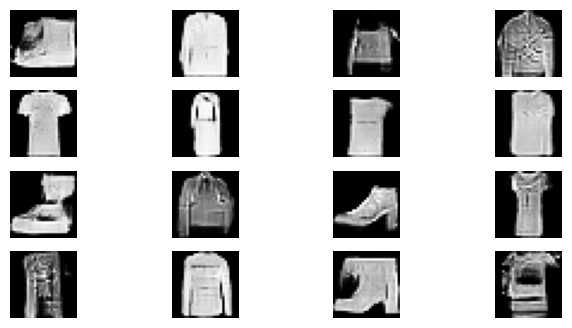

 34%|███▍      | 17/50 [04:20<08:18, 15.10s/it]

Time for epoch 17 is 15.130154609680176 sec
Training started with  epoch 18 with 1875 batches..
Losses after epoch    18: generator 0.941, discriminator 1.137, real_score 59.92%, fake_score 42.48%


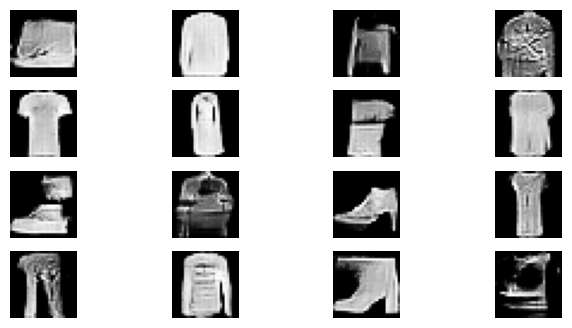

 36%|███▌      | 18/50 [04:36<08:03, 15.11s/it]

Time for epoch 18 is 15.137204885482788 sec
Training started with  epoch 19 with 1875 batches..
Losses after epoch    19: generator 0.843, discriminator 1.325, real_score 53.04%, fake_score 45.58%


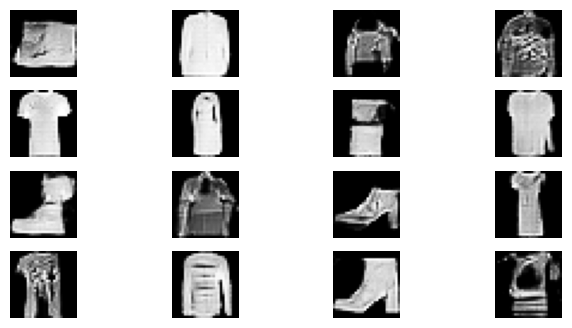

 38%|███▊      | 19/50 [04:51<07:47, 15.08s/it]

Time for epoch 19 is 14.995437860488892 sec
Training started with  epoch 20 with 1875 batches..
Losses after epoch    20: generator 0.987, discriminator 1.015, real_score 63.68%, fake_score 39.56%


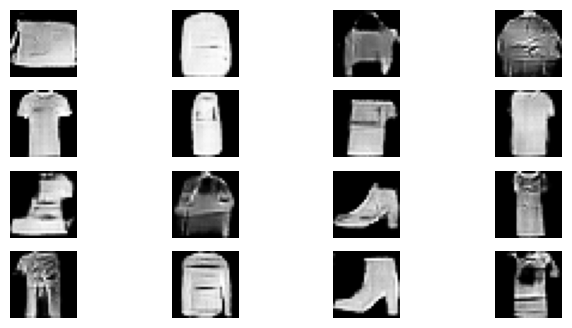

 40%|████      | 20/50 [05:06<07:31, 15.05s/it]

Time for epoch 20 is 14.99260926246643 sec
Training started with  epoch 21 with 1875 batches..
Losses after epoch    21: generator 0.720, discriminator 1.337, real_score 55.55%, fake_score 50.19%


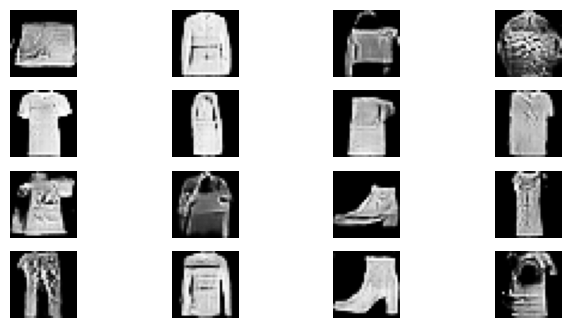

 42%|████▏     | 21/50 [05:20<07:15, 15.00s/it]

Time for epoch 21 is 14.873509168624878 sec
Training started with  epoch 22 with 1875 batches..
Losses after epoch    22: generator 0.969, discriminator 1.285, real_score 49.57%, fake_score 40.07%


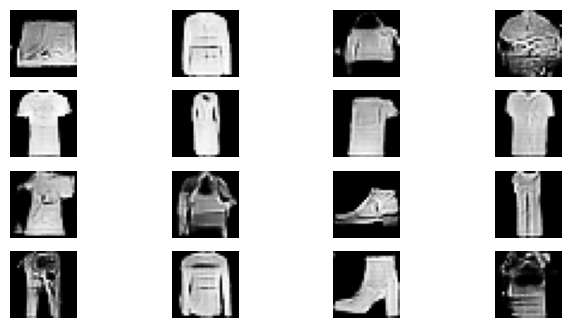

 44%|████▍     | 22/50 [05:36<07:04, 15.16s/it]

Time for epoch 22 is 15.529739141464233 sec
Training started with  epoch 23 with 1875 batches..
Losses after epoch    23: generator 0.838, discriminator 1.309, real_score 58.19%, fake_score 47.41%


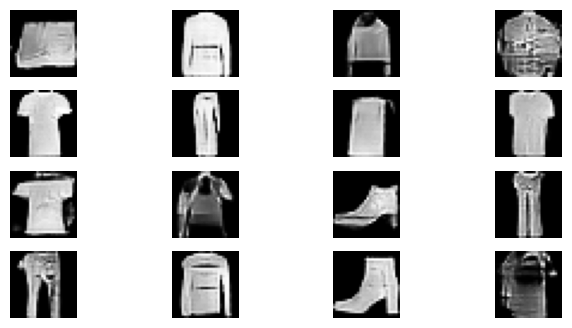

 46%|████▌     | 23/50 [05:51<06:48, 15.13s/it]

Time for epoch 23 is 15.054063320159912 sec
Training started with  epoch 24 with 1875 batches..
Losses after epoch    24: generator 0.916, discriminator 1.268, real_score 52.62%, fake_score 42.88%


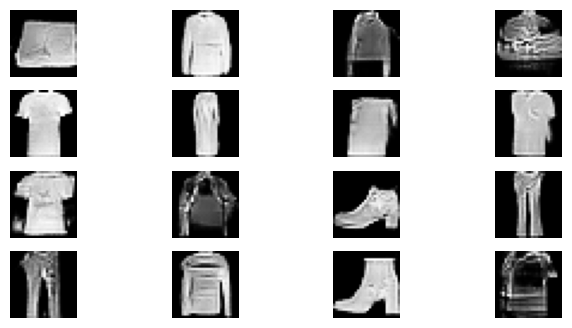

 48%|████▊     | 24/50 [06:06<06:31, 15.07s/it]

Time for epoch 24 is 14.933096885681152 sec
Training started with  epoch 25 with 1875 batches..
Losses after epoch    25: generator 1.089, discriminator 1.298, real_score 44.89%, fake_score 35.78%


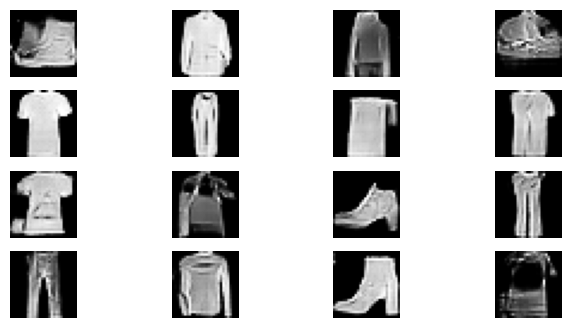

 50%|█████     | 25/50 [06:21<06:17, 15.10s/it]

Time for epoch 25 is 15.17345142364502 sec
Training started with  epoch 26 with 1875 batches..
Losses after epoch    26: generator 0.919, discriminator 1.162, real_score 59.49%, fake_score 43.34%


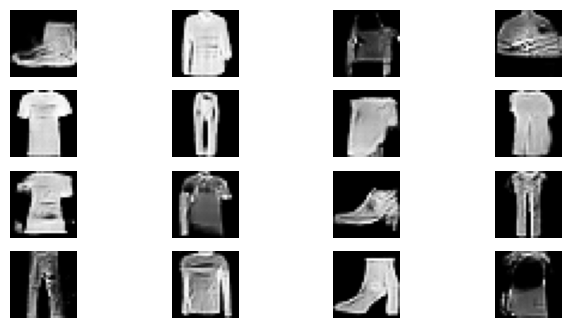

 52%|█████▏    | 26/50 [06:36<06:04, 15.17s/it]

Time for epoch 26 is 15.314786195755005 sec
Training started with  epoch 27 with 1875 batches..
Losses after epoch    27: generator 1.110, discriminator 1.197, real_score 53.95%, fake_score 37.75%


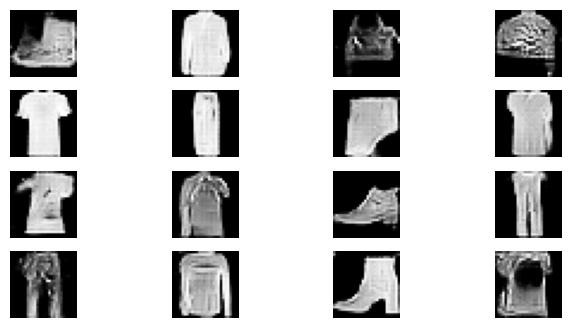

 54%|█████▍    | 27/50 [06:51<05:48, 15.14s/it]

Time for epoch 27 is 15.068101406097412 sec
Training started with  epoch 28 with 1875 batches..
Losses after epoch    28: generator 0.824, discriminator 1.232, real_score 57.02%, fake_score 46.13%


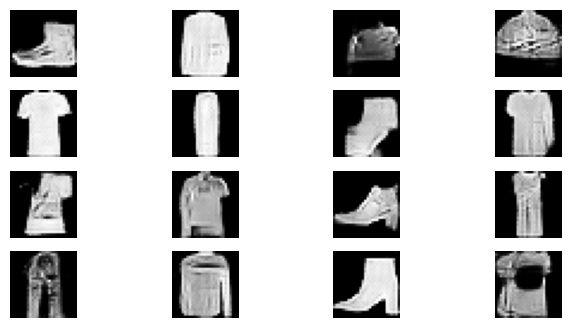

 56%|█████▌    | 28/50 [07:06<05:31, 15.08s/it]

Time for epoch 28 is 14.949398040771484 sec
Training started with  epoch 29 with 1875 batches..
Losses after epoch    29: generator 0.898, discriminator 1.131, real_score 60.14%, fake_score 43.14%


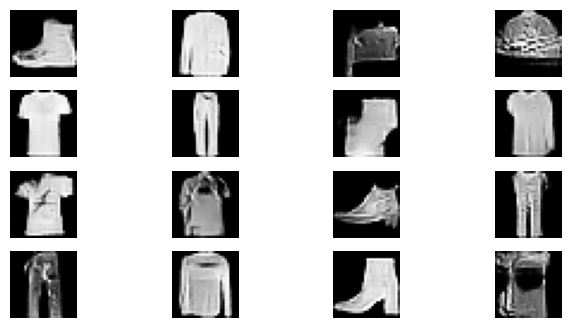

 58%|█████▊    | 29/50 [07:21<05:15, 15.03s/it]

Time for epoch 29 is 14.894727945327759 sec
Training started with  epoch 30 with 1875 batches..
Losses after epoch    30: generator 1.095, discriminator 1.139, real_score 54.71%, fake_score 36.50%


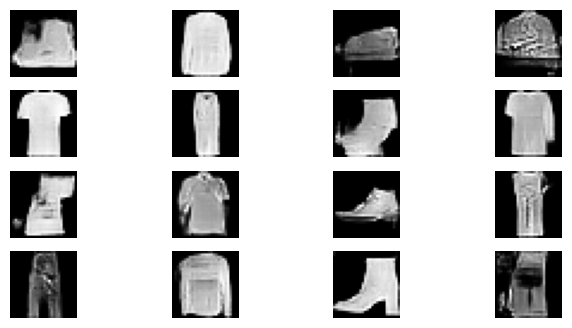

 60%|██████    | 30/50 [07:37<05:04, 15.23s/it]

Time for epoch 30 is 15.699015617370605 sec
Training started with  epoch 31 with 1875 batches..
Losses after epoch    31: generator 0.936, discriminator 1.121, real_score 61.65%, fake_score 42.88%


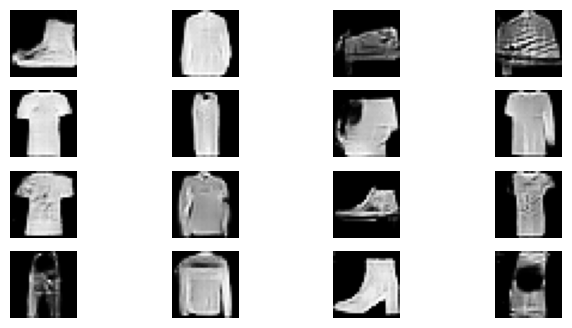

 62%|██████▏   | 31/50 [07:52<04:48, 15.19s/it]

Time for epoch 31 is 15.082093715667725 sec
Training started with  epoch 32 with 1875 batches..
Losses after epoch    32: generator 0.893, discriminator 1.399, real_score 47.28%, fake_score 42.82%


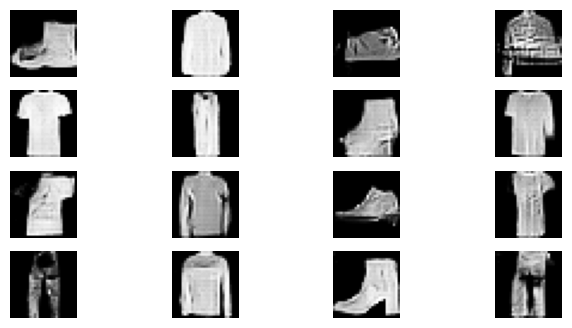

 64%|██████▍   | 32/50 [08:07<04:32, 15.11s/it]

Time for epoch 32 is 14.93771243095398 sec
Training started with  epoch 33 with 1875 batches..
Losses after epoch    33: generator 0.862, discriminator 1.148, real_score 60.78%, fake_score 44.16%


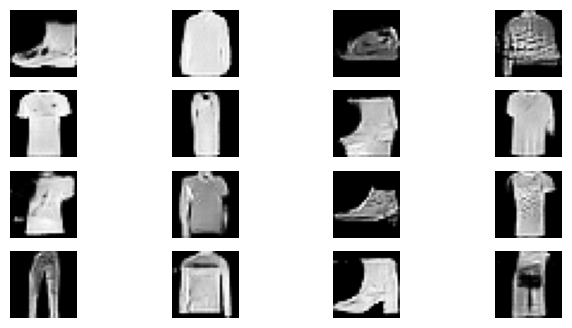

 66%|██████▌   | 33/50 [08:22<04:17, 15.13s/it]

Time for epoch 33 is 15.158675193786621 sec
Training started with  epoch 34 with 1875 batches..
Losses after epoch    34: generator 1.007, discriminator 1.018, real_score 63.11%, fake_score 39.19%


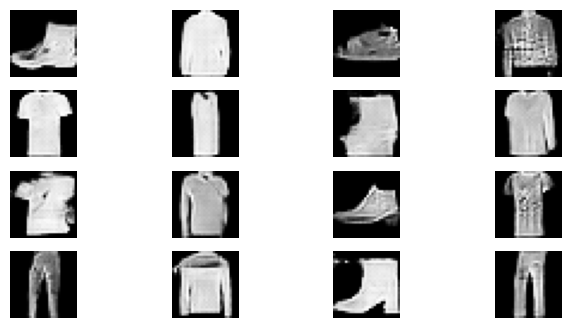

 68%|██████▊   | 34/50 [08:37<04:02, 15.15s/it]

Time for epoch 34 is 15.189618825912476 sec
Training started with  epoch 35 with 1875 batches..
Losses after epoch    35: generator 1.160, discriminator 1.403, real_score 41.20%, fake_score 33.71%


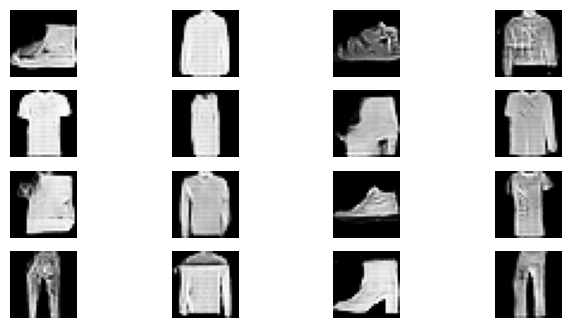

 70%|███████   | 35/50 [08:53<03:47, 15.15s/it]

Time for epoch 35 is 15.157825946807861 sec
Training started with  epoch 36 with 1875 batches..
Losses after epoch    36: generator 0.789, discriminator 1.450, real_score 48.98%, fake_score 47.72%


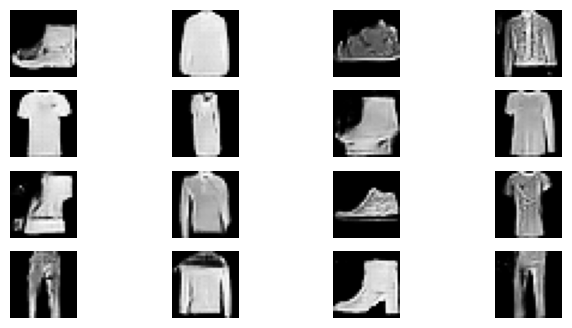

 72%|███████▏  | 36/50 [09:08<03:31, 15.08s/it]

Time for epoch 36 is 14.890545129776001 sec
Training started with  epoch 37 with 1875 batches..
Losses after epoch    37: generator 0.828, discriminator 1.010, real_score 70.05%, fake_score 45.70%


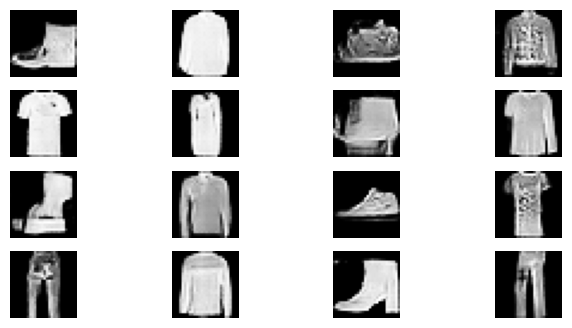

 74%|███████▍  | 37/50 [09:22<03:15, 15.04s/it]

Time for epoch 37 is 14.964325666427612 sec
Training started with  epoch 38 with 1875 batches..
Losses after epoch    38: generator 0.834, discriminator 1.548, real_score 42.97%, fake_score 45.71%


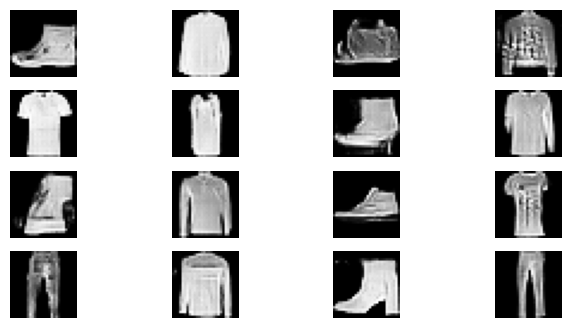

 76%|███████▌  | 38/50 [09:38<03:02, 15.19s/it]

Time for epoch 38 is 15.521813869476318 sec
Training started with  epoch 39 with 1875 batches..
Losses after epoch    39: generator 0.904, discriminator 1.266, real_score 52.78%, fake_score 42.68%


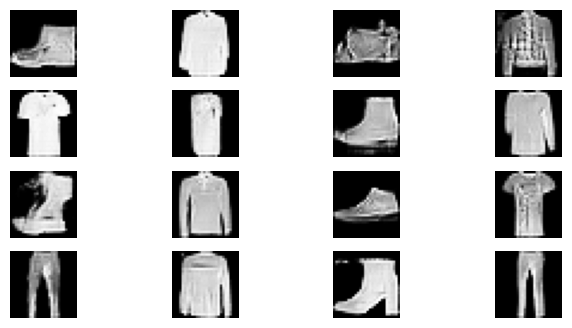

 78%|███████▊  | 39/50 [09:53<02:46, 15.13s/it]

Time for epoch 39 is 15.00089716911316 sec
Training started with  epoch 40 with 1875 batches..
Losses after epoch    40: generator 0.942, discriminator 1.456, real_score 42.75%, fake_score 41.42%


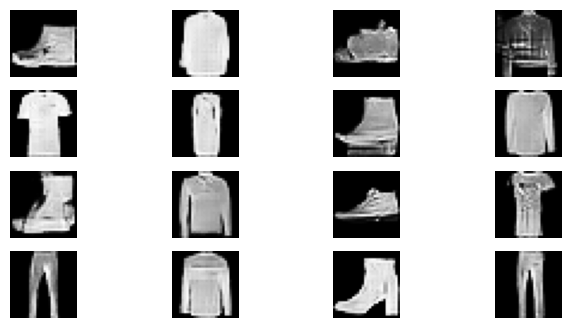

 80%|████████  | 40/50 [10:11<02:38, 15.89s/it]

Time for epoch 40 is 17.63951587677002 sec
Training started with  epoch 41 with 1875 batches..
Losses after epoch    41: generator 0.837, discriminator 1.215, real_score 56.83%, fake_score 44.97%


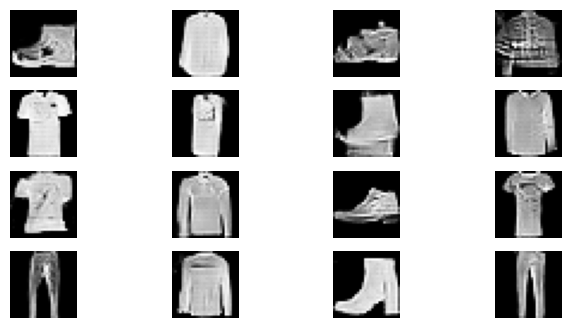

 82%|████████▏ | 41/50 [10:27<02:24, 16.01s/it]

Time for epoch 41 is 16.286888360977173 sec
Training started with  epoch 42 with 1875 batches..
Losses after epoch    42: generator 1.085, discriminator 1.391, real_score 42.58%, fake_score 35.93%


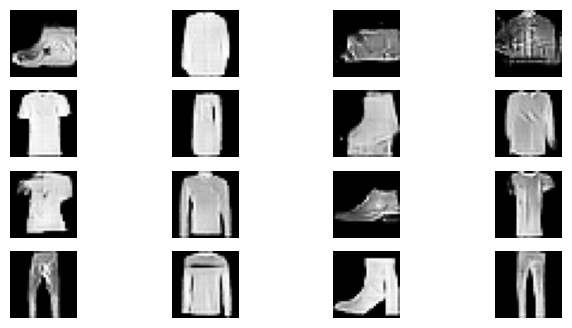

 84%|████████▍ | 42/50 [10:42<02:05, 15.71s/it]

Time for epoch 42 is 14.985954761505127 sec
Training started with  epoch 43 with 1875 batches..
Losses after epoch    43: generator 0.749, discriminator 1.484, real_score 49.95%, fake_score 49.81%


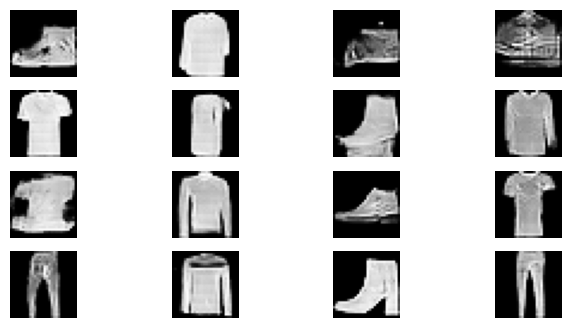

 86%|████████▌ | 43/50 [10:57<01:48, 15.51s/it]

Time for epoch 43 is 15.038065433502197 sec
Training started with  epoch 44 with 1875 batches..
Losses after epoch    44: generator 0.933, discriminator 1.335, real_score 47.93%, fake_score 41.23%


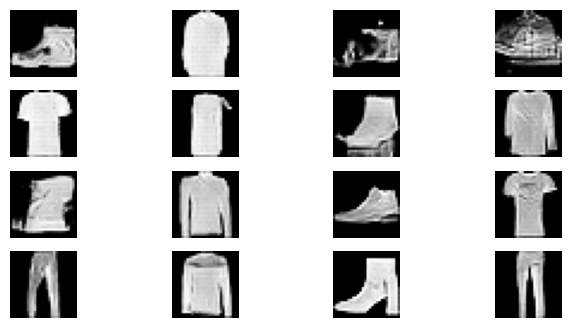

 88%|████████▊ | 44/50 [11:12<01:32, 15.35s/it]

Time for epoch 44 is 14.965932130813599 sec
Training started with  epoch 45 with 1875 batches..
Losses after epoch    45: generator 0.886, discriminator 1.233, real_score 54.30%, fake_score 43.00%


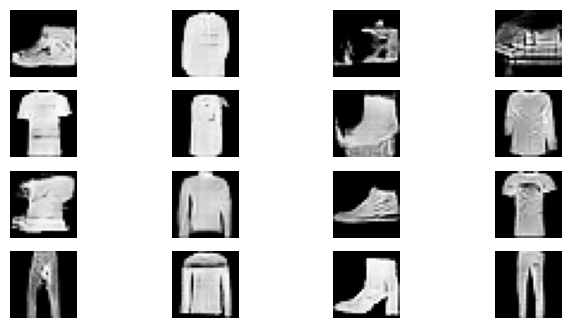

 90%|█████████ | 45/50 [11:28<01:17, 15.43s/it]

Time for epoch 45 is 15.614217758178711 sec
Training started with  epoch 46 with 1875 batches..
Losses after epoch    46: generator 0.710, discriminator 1.526, real_score 50.76%, fake_score 51.59%


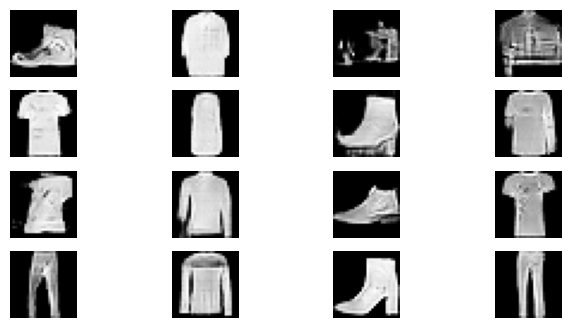

 92%|█████████▏| 46/50 [11:42<01:01, 15.26s/it]

Time for epoch 46 is 14.873379230499268 sec
Training started with  epoch 47 with 1875 batches..
Losses after epoch    47: generator 0.702, discriminator 1.559, real_score 46.96%, fake_score 50.84%


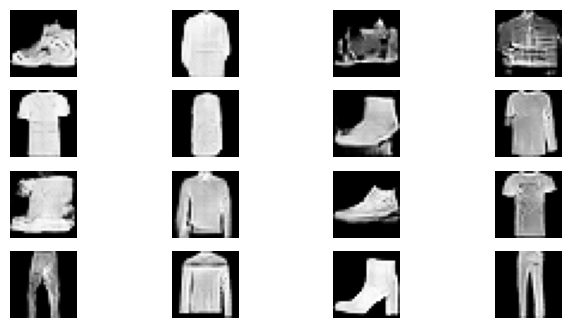

 94%|█████████▍| 47/50 [11:57<00:45, 15.17s/it]

Time for epoch 47 is 14.940628051757812 sec
Training started with  epoch 48 with 1875 batches..
Losses after epoch    48: generator 0.701, discriminator 1.305, real_score 62.01%, fake_score 52.38%


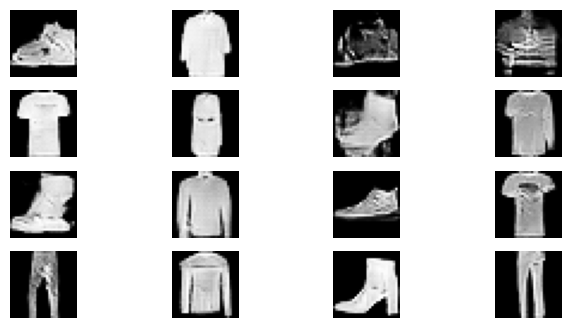

 96%|█████████▌| 48/50 [12:12<00:30, 15.09s/it]

Time for epoch 48 is 14.919014692306519 sec
Training started with  epoch 49 with 1875 batches..
Losses after epoch    49: generator 0.821, discriminator 1.424, real_score 49.05%, fake_score 46.21%


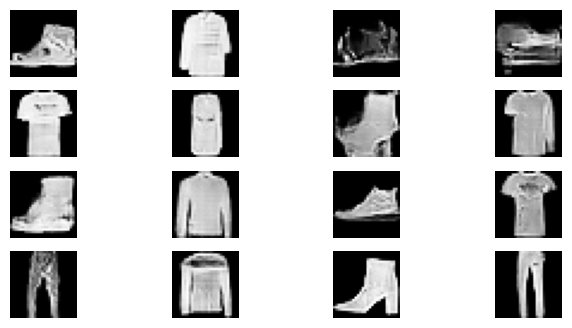

 98%|█████████▊| 49/50 [12:28<00:15, 15.16s/it]

Time for epoch 49 is 15.307777881622314 sec
Training started with  epoch 50 with 1875 batches..
Losses after epoch    50: generator 0.857, discriminator 1.174, real_score 57.90%, fake_score 44.12%


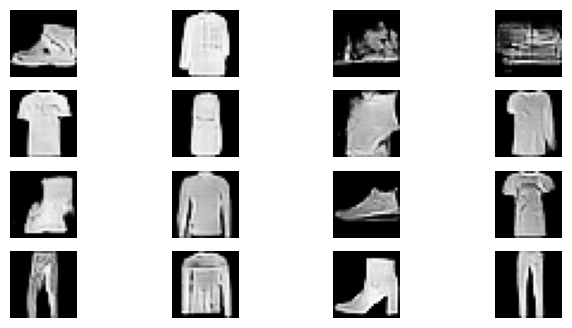

100%|██████████| 50/50 [12:43<00:00, 15.27s/it]

Time for epoch 50 is 15.375192403793335 sec


In [22]:
gen_loss_epochs, disc_loss_epochs,real_score_list,fake_score_list = train(train_dataset, epochs = epochs)

Real and fake scores both converge towards 0.5. This means that the discriminator is unable to differentiate between real and fake images. It has a 50% chance of getting classifications right (or wrong)

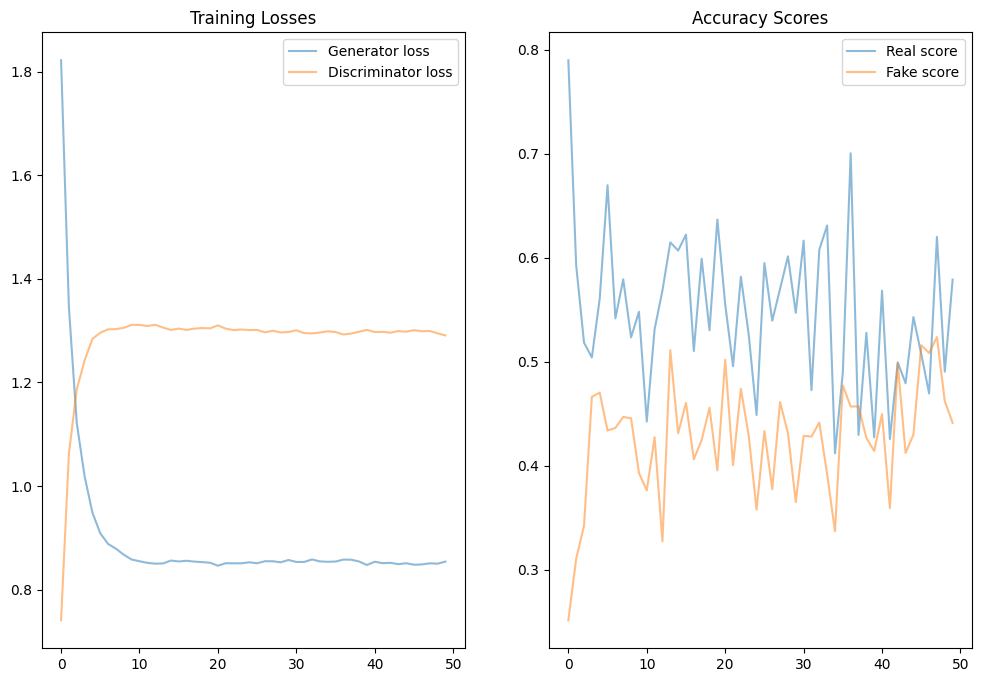

In [23]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()